In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.feature_selection import RFECV, SequentialFeatureSelector
from tqdm import tqdm
import sys
sys.path.append('../')

from TS_model.feature_engeneering import FeatureEngineer
from TS_model.feature_selection import WrapperMethod, StabilityAnalysis, DefaultMethod, FilterMethod

%load_ext autoreload
%autoreload 2

# Выгрузка изначальных данных & Feature engeneering

In [2]:
data = pd.read_csv('../Data/final.csv', parse_dates=['date'])
data.columns = data.columns.str.lower()
data['date'] = pd.to_datetime(data['date'])

macro_cols = [
    'digitalization_level', 'age_0_14', 'age_15_64', 'age_65_plus',
    'population_density', 'consumer_confidence_index', 'gdp_per_capita',
    'unemployment_rate', 'trade_balance', 'inflation_rate', 'close', 'usd_rate'
]
macro_df = data.set_index('date')[macro_cols]

print(data.columns)
macro_df

Index(['date', 'income', 'outcome', 'balance', 'тип дня', 'рабочий день (1/0)',
       'ндс', 'ндфл', 'страховые взносы', 'акцизы',
       'налог на имущество организаций', 'транспортный налог',
       'налог на землю', 'налог на прибыль', 'digitalization_level',
       'age_0_14', 'age_15_64', 'age_65_plus', 'population_density',
       'consumer_confidence_index', 'gdp_per_capita', 'unemployment_rate',
       'trade_balance', 'inflation_rate', 'close', 'usd_rate'],
      dtype='object')


,digitalization_level,age_0_14,age_15_64,age_65_plus,population_density,consumer_confidence_index,gdp_per_capita,unemployment_rate,trade_balance,inflation_rate,close,usd_rate
date,,,,,,,,,,,,
2017-01-09,76.0,17.458149,68.300922,14.240929,8.871858,71.088007,10658.913086,5.238,8.351502e+10,3.683329,2211.25,59.564999
2017-01-10,76.0,17.458149,68.300922,14.240929,8.871858,71.088007,10658.913086,5.238,8.351502e+10,3.683329,2237.49,60.102501
2017-01-11,76.0,17.458149,68.300922,14.240929,8.871858,71.088007,10658.913086,5.238,8.351502e+10,3.683329,2218.61,60.139999
2017-01-12,76.0,17.458149,68.300922,14.240929,8.871858,71.088007,10658.913086,5.238,8.351502e+10,3.683329,2212.00,59.778099
2017-01-13,76.0,17.458149,68.300922,14.240929,8.871858,71.088007,10658.913086,5.238,8.351502e+10,3.683329,2195.19,59.432499
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-25,88.2,17.720482,66.546119,15.733399,8.838488,67.066121,12521.522461,4.749,1.722832e+11,6.694459,3439.30,76.616203
2021-03-26,88.2,17.720482,66.546119,15.733399,8.838488,67.066121,12521.522461,4.749,1.722832e+11,6.694459,3489.83,76.117104
2021-03-29,88.2,17.720482,66.546119,15.733399,8.838488,67.066121,12521.522461,4.749,1.722832e+11,6.694459,3529.33,75.661102


In [3]:
tax_dates_dict = {
    "2017-01-25": ["НДФЛ", "НДС"],
    "2017-02-15": ["Страховые взносы"],
    "2017-04-28": ["НДФЛ", "НДС"],
    "2017-05-01": ["Акцизы"],
    "2017-10-10": ["Налог на имущество организаций"],
    "2018-01-25": ["НДФЛ", "НДС"],
    "2018-02-15": ["Налог на землю"],
    "2019-04-25": ["НДС"],
    "2019-07-01": ["Транспортный налог"],
    "2020-07-15": ["НДФЛ"],
    "2021-03-15": ["НДФЛ", "Страховые взносы", "Налог на прибыль"],
}


tax_dates = list(tax_dates_dict.keys())

tax_dates = pd.to_datetime(tax_dates)
feature_extactor = FeatureEngineer(data)

In [4]:
feature_extactor = FeatureEngineer(data, date_col='date')

In [5]:
data.columns

Index(['date', 'income', 'outcome', 'balance', 'тип дня', 'рабочий день (1/0)',
       'ндс', 'ндфл', 'страховые взносы', 'акцизы',
       'налог на имущество организаций', 'транспортный налог',
       'налог на землю', 'налог на прибыль', 'digitalization_level',
       'age_0_14', 'age_15_64', 'age_65_plus', 'population_density',
       'consumer_confidence_index', 'gdp_per_capita', 'unemployment_rate',
       'trade_balance', 'inflation_rate', 'close', 'usd_rate'],
      dtype='object')

In [6]:
feature_extactor = (
    feature_extactor.add_lag_features(lags=[1, 2, 7])
      .add_rolling_features(windows=[3, 7, 30])
      .add_seasonal_features()
      .add_macro_features(macro_df)
)


feature_extactor = feature_extactor.add_special_dates(tax_dates)

/Users/legornevas/Desktop/TS_project/TS_project/notebooks/../TS_model/feature_engeneering.py:82: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.features.fillna(method='ffill', inplace=True)


In [7]:
features, target = feature_extactor.get_feature_df()

# Feature selection

In [8]:
tscv = TimeSeriesSplit(n_splits=5)

## Встроенные методы

Index(['balance_lag1', 'outcome_lag1', 'outcome_lag2', 'balance_lag7', 'month',
       'day_of_week_sin', 'day_of_week_cos', 'dow_0', 'dow_3',
       'digitalization_level', 'age_65_plus', 'population_density',
       'inflation_rate', 'close'],
      dtype='object')


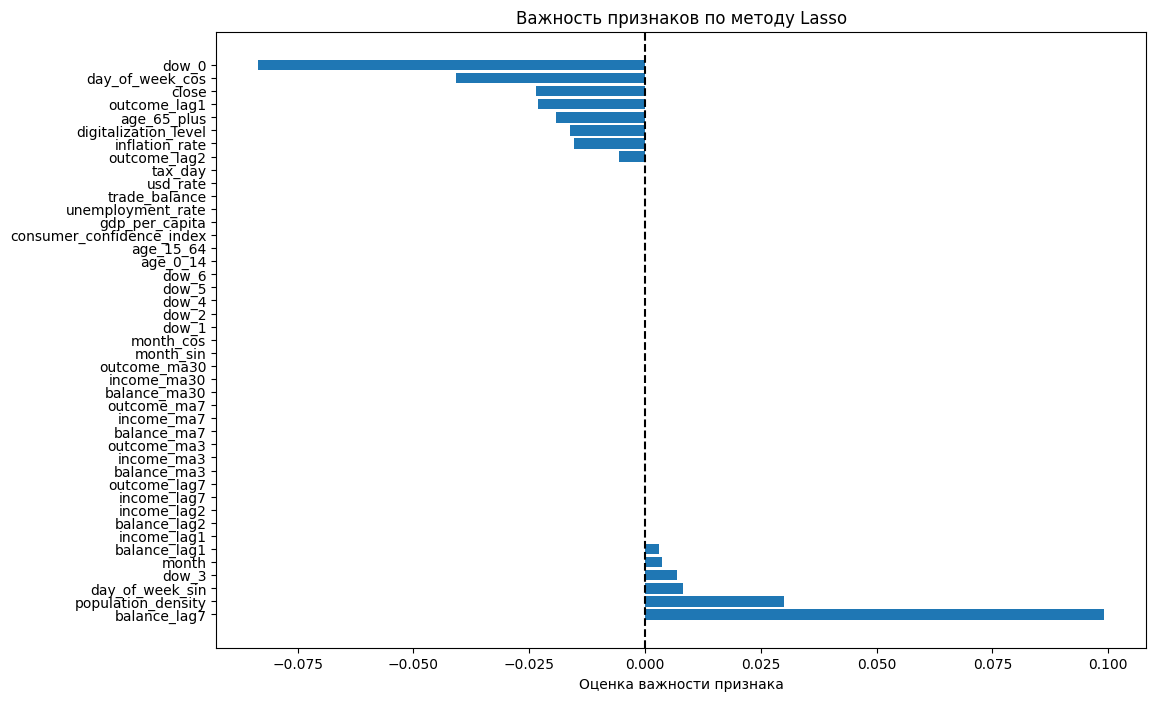

In [9]:
default = DefaultMethod()
default.fit(features, target)

lasso = LassoCV(cv=tscv, max_iter=10000, random_state=42)
print(default.implement(lasso))
default.vizualize()

Index(['balance_lag1', 'income_lag1', 'outcome_lag1', 'balance_lag2',
       'income_lag2', 'outcome_lag2', 'balance_lag7', 'income_lag7',
       'outcome_lag7', 'balance_ma3', 'income_ma3', 'outcome_ma3',
       'balance_ma7', 'income_ma7', 'outcome_ma7', 'balance_ma30',
       'income_ma30', 'outcome_ma30', 'month', 'day_of_week_cos', 'month_sin',
       'month_cos', 'dow_0', 'close', 'usd_rate'],
      dtype='object')


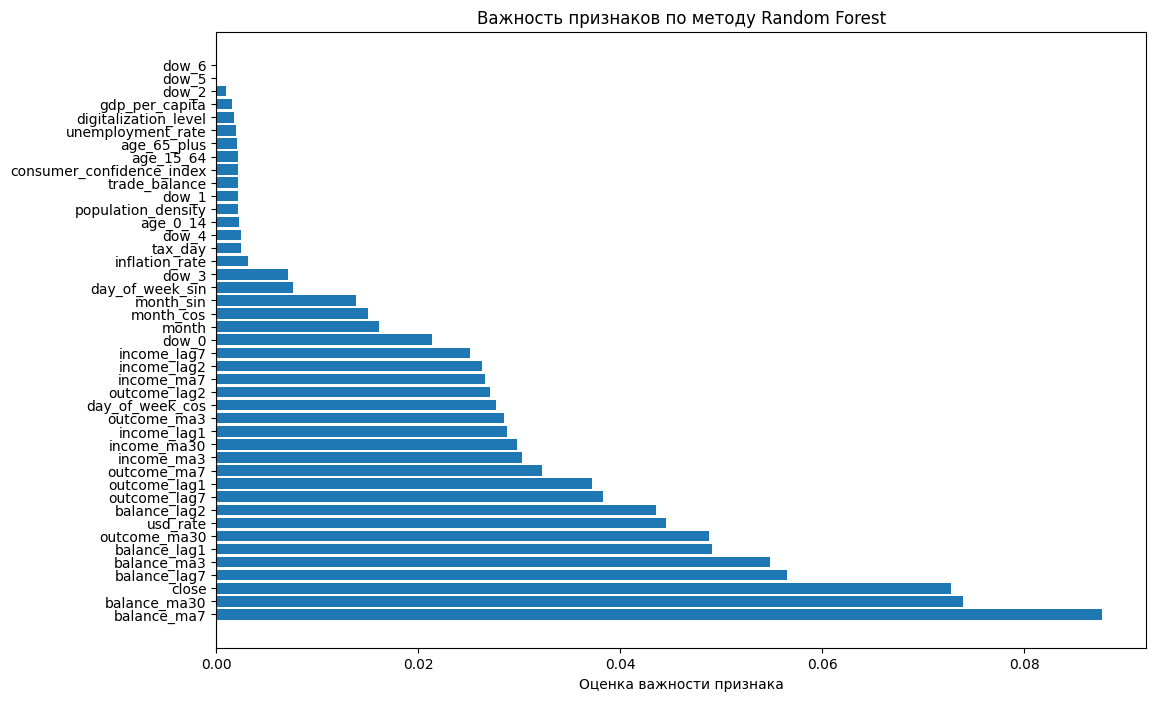

In [10]:
default = DefaultMethod()
default.fit(features, target)

random_forest = RandomForestRegressor(n_estimators=500, random_state=42)
print(default.implement(random_forest))
default.vizualize()

## Оберточные методы

Отобранные признаки на основе lasso: Index(['balance_lag1', 'outcome_lag1', 'outcome_lag2', 'balance_lag7',
       'income_lag7', 'outcome_lag7', 'balance_ma3', 'month',
       'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'dow_0',
       'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6',
       'digitalization_level', 'age_0_14', 'age_15_64', 'age_65_plus',
       'population_density', 'consumer_confidence_index', 'gdp_per_capita',
       'unemployment_rate', 'trade_balance', 'inflation_rate', 'close',
       'usd_rate', 'tax_day'],
      dtype='object')


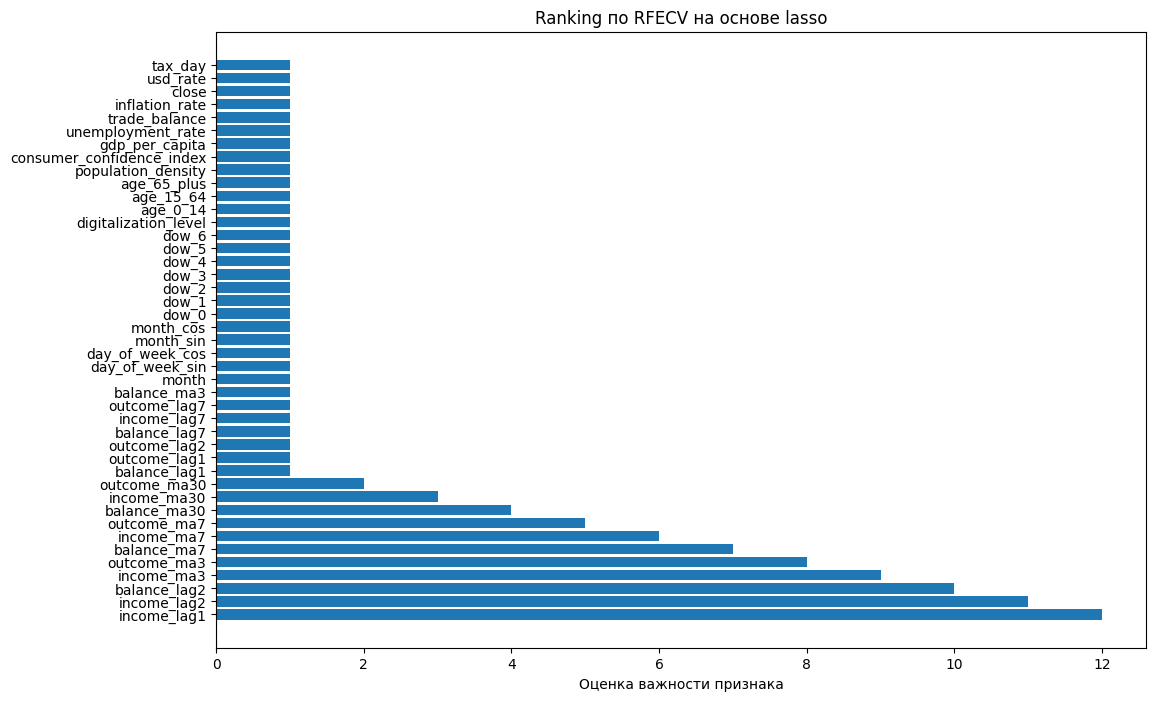

Отобранные признаки на основе elastic_net: Index(['balance_lag7', 'dow_0', 'dow_3', 'age_15_64', 'tax_day'], dtype='object')


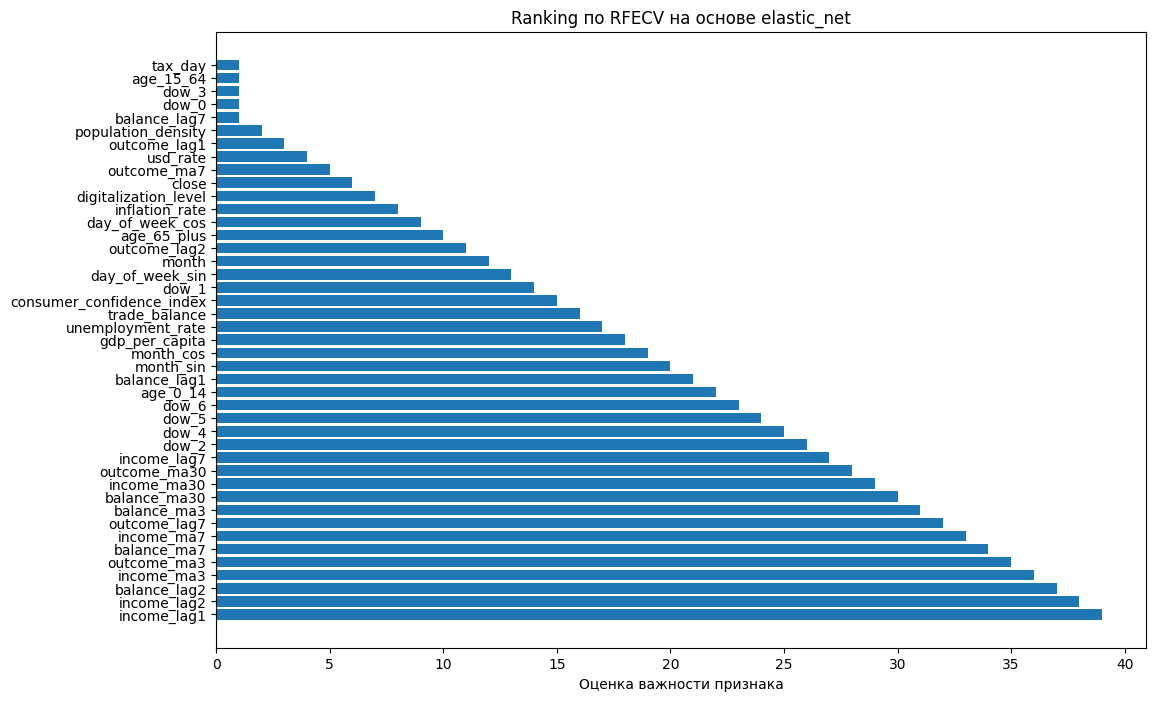

Отобранные признаки на основе random_forest: Index(['outcome_lag1', 'balance_lag7', 'balance_ma3', 'balance_ma7',
       'balance_ma30', 'close'],
      dtype='object')


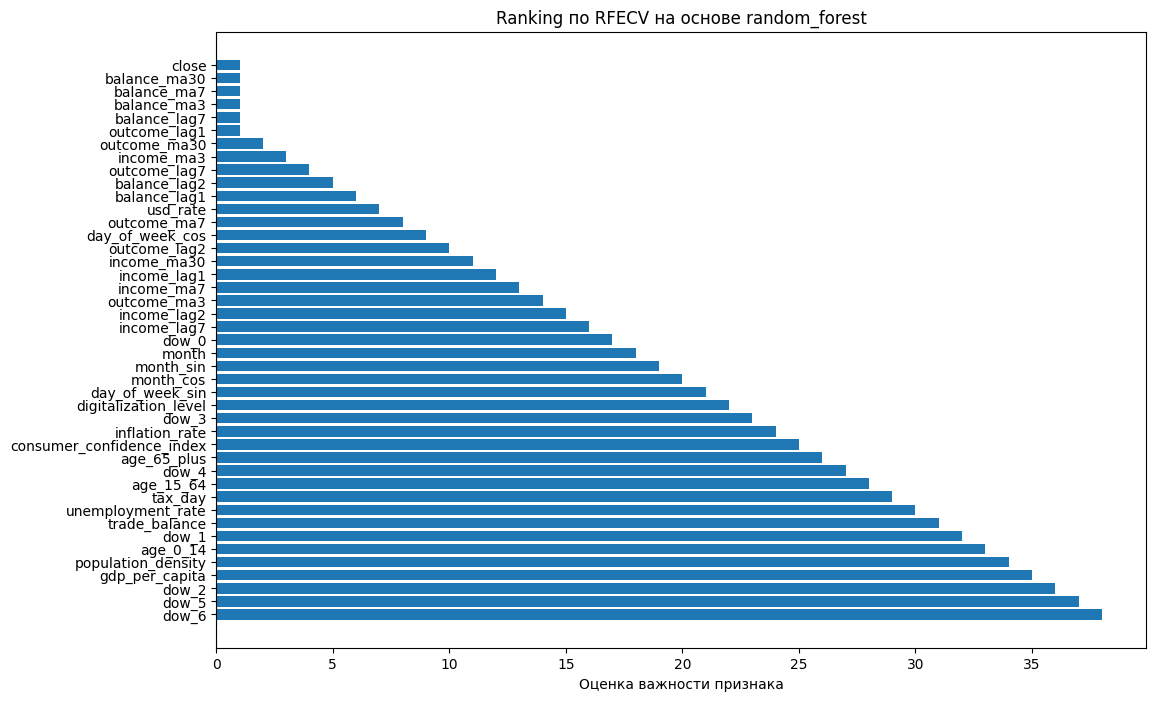

In [11]:
models_for_wrapper = {
    'lasso': LassoCV(cv=tscv, max_iter=10000, random_state=42),
    'elastic_net': ElasticNetCV(cv=tscv, max_iter=10000, random_state=42),
    'random_forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

wrapper = WrapperMethod()
wrapper.fit(features, target)

for name, model in models_for_wrapper.items():
    res = wrapper.implement(model, tscv)
    print(f'Отобранные признаки на основе {name}: {res}', end='\n')

    wrapper.vizualize(f'Ranking по RFECV на основе {name}')

## Фильтрационные методы

['month', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'dow_4', 'digitalization_level', 'age_0_14', 'age_15_64', 'age_65_plus', 'population_density', 'consumer_confidence_index', 'gdp_per_capita', 'unemployment_rate', 'trade_balance', 'inflation_rate']


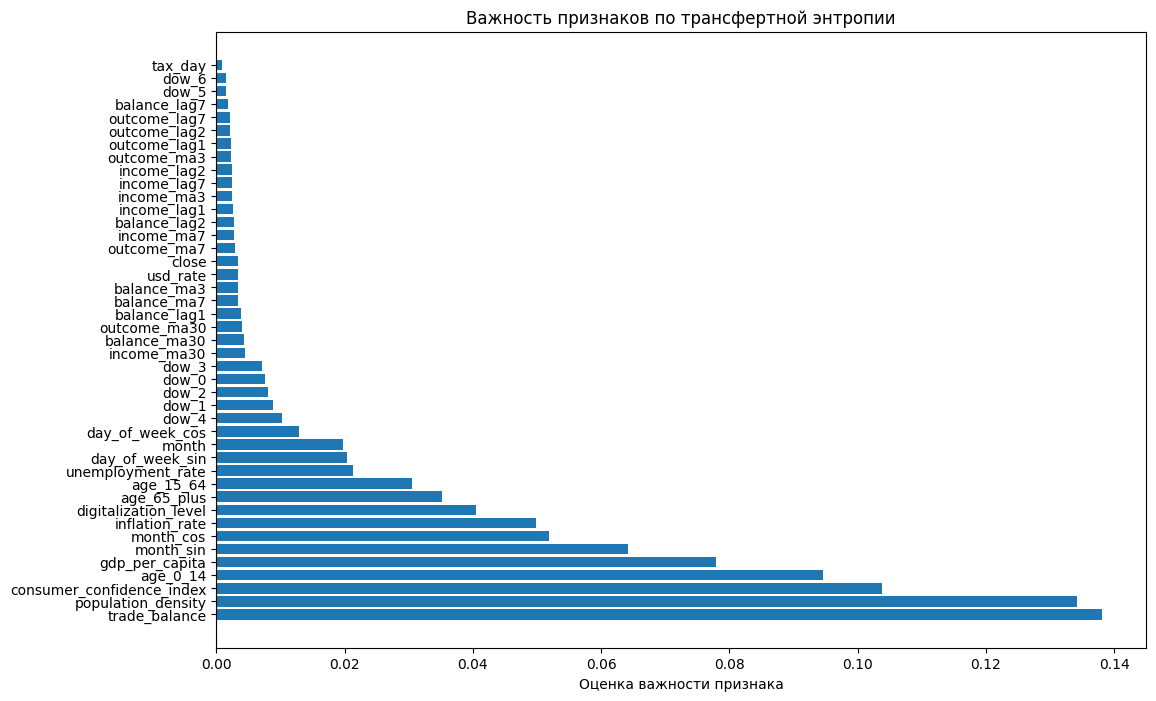

In [12]:
filter = FilterMethod()
filter.fit(features, target)

print(filter.implement(k=30))
filter.vizualize('Важность признаков по трансфертной энтропии')

# Оценка стабильности

In [14]:
method_params = {
    'default': {
        'Lasso': {'model': LassoCV(cv=tscv, max_iter=10000, random_state=42)},
        'RandomForest': {'model': RandomForestRegressor(n_estimators=500, random_state=42)}
    },
    'wrapper': {
        # 'Lasso': {'model': LassoCV(cv=tscv, max_iter=10000, random_state=42), 'tscv': tscv},
        # 'ElasticNet': {'model': ElasticNetCV(cv=tscv, max_iter=10000, random_state=42), 'tscv': tscv},
        'RandomForest': {'model': RandomForestRegressor(n_estimators=100, random_state=42), 'tscv': tscv}
    },
    'filter': {
        'TransferEntropy': {'k': 5}
    }
}

methods = []
method_configs = []
stabilities = []

stability_eval = StabilityAnalysis()
stability_eval.fit(features, target)

for method, params in tqdm(method_params.items()):
    for method_config, param in params.items():
        stability_eval.collect_binary(n_splits=5, method=method, **param)
        method_stability = stability_eval.implement()

        methods.append(method)
        method_configs.append(method_config)
        stabilities.append(method_stability)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [06:29<00:00, 129.77s/it]


In [15]:
pd.DataFrame(
    {
        'method': methods,
        'method_config': method_configs,
        'stability': stabilities
    }
)

,method,method_config,stability
0,default,Lasso,0.230353
1,default,RandomForest,0.924001
2,wrapper,RandomForest,0.274403
3,filter,TransferEntropy,0.392655
